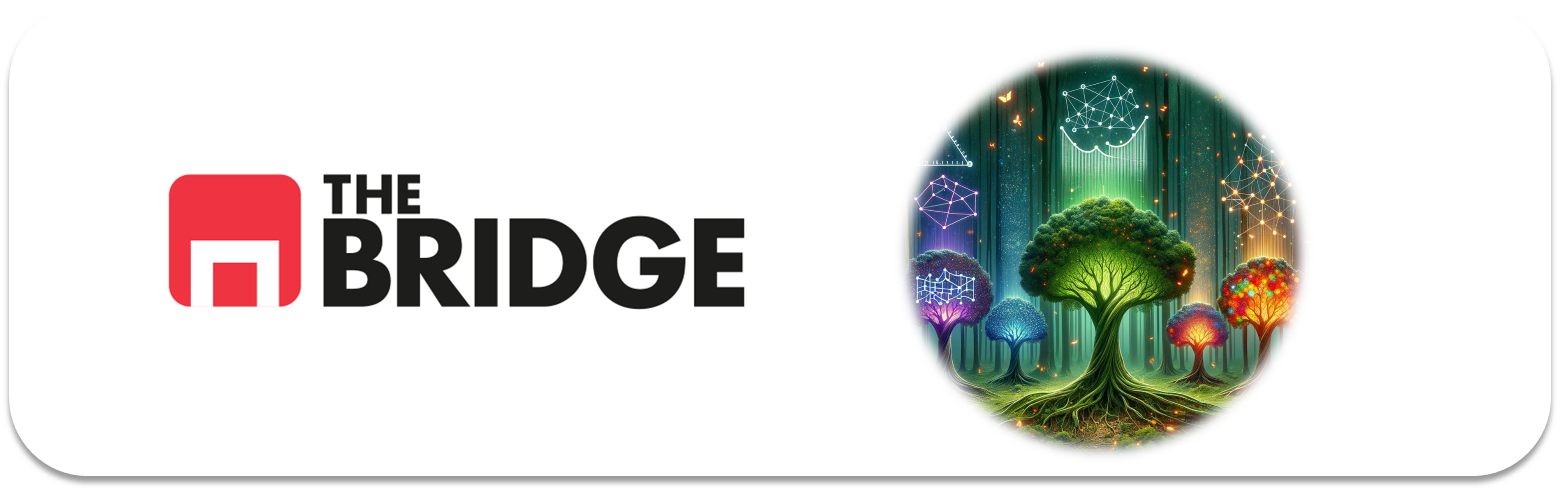

## PRACTICA OBLIGATORIA: **Ensembles: Bagging y Boosting**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [14]:
import pandas as pd

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [15]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

In [16]:

import numpy as np
import pandas as pd

# Para dividir en train/test
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Modelos de bagging y boosting
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

# Árbol base para bagging
from sklearn.tree import DecisionTreeClassifier

# Métricas finales
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 2. CARGAR DATASET DESDE LA URL

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg','plas','pres','skin','test','mass','pedi','age','class']


df = pd.read_csv(url, names=names)
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Hemos cargado el dataset de Pima Indians Diabetes desde la URL indicada en el enunciado y hemos asignado los nombres de las columnas sugeridos. A partir de este dataframe trabajaremos el problema de clasificación: predecir si una paciente desarrollará diabetes (class = 1) o no (class = 0).

In [17]:

df.info()

df.describe()

df['class'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


class
0    0.651042
1    0.348958
Name: proportion, dtype: float64

In [ ]:
pd.DataFrame({"features": base_clf.feature_names_in_, "importance": base_clf.feature_importances_}).sort_values("importance",ascending = False)

In [18]:
# 1. SEPARAR FEATURES (X) Y TARGET (y)

X = df.drop('class', axis=1)  # todas las columnas menos la variable objetivo
y = df['class']               # variable objetivo (0 = no diabetes, 1 = diabetes)

# 2. DIVISION TRAIN / TEST
# Usamos stratify=y para mantener la proporción de clases en ambos conjuntos
# test_size=0.2 significa 80% train, 20% test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Tamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)

Tamaño train: (614, 8)
Tamaño test: (154, 8)


Dividimos los datos en train (80%) y test (20%).
El conjunto de train se utiliza para entrenar modelos y hacer validación cruzada.
El conjunto de test lo dejamos “guardado” y solo lo usamos al final para evaluar el mejor modelo (tal y como pide el enunciado, no lo usamos para comparar modelos).

In [19]:
# 1. DEFINIMOS LOS MODELOS DE BAGGING Y BOOSTING EN UN DICCIONARIO

# Árbol base para bagging
base_tree = DecisionTreeClassifier(
    random_state=42
)

modelos = {
    "Random Forest (Bagging)": RandomForestClassifier(
        n_estimators=200,       # número de árboles
        max_depth=None,         # profundidad de los árboles (None = sin límite)
        random_state=42
    ),
    
    "Bagging + Árbol": BaggingClassifier(
        estimator=base_tree,    # modelo base (árbol de decisión)
        n_estimators=200,       # número de modelos en el ensemble
        random_state=42
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,       # número de etapas de boosting
        learning_rate=0.05,     # tasa de aprendizaje
        max_depth=3,            # profundidad de los árboles internos
        random_state=42
    )
}

In [20]:
# 2. CONFIGURAR VALIDACIÓN CRUZADA ESTRATIFICADA
# StratifiedKFold mantiene la proporción de clases en cada "fold"

cv = StratifiedKFold(
    n_splits=5,        # número de particiones (folds)
    shuffle=True, 
    random_state=42
)

# 3. EVALUAR CADA MODELO CON CROSS-VALIDATION (SOLO TRAIN)

resultados_cv = {}

for nombre, modelo in modelos.items():
    # cross_val_score entrena y valida el modelo en diferentes particiones del train
    scores = cross_val_score(
        modelo,
        X_train,
        y_train,
        cv=5,
        scoring="balanced_accuracy"  # Es decir, sirve para evaluar el modelo, no para entrenarlo.
    )
    
    resultados_cv[nombre] = scores
    
    print(f"Modelo: {nombre}")
    print(f"  Accuracy medio CV: {scores.mean():.4f}")
    print(f"  Desviación std:    {scores.std():.4f}")
    print(f"  Scores individuales: {scores}")
    print("-" * 50)

Modelo: Random Forest (Bagging)
  Accuracy medio CV: 0.7314
  Desviación std:    0.0326
  Scores individuales: [0.70857558 0.7747093  0.69069767 0.71831395 0.76458333]
--------------------------------------------------
Modelo: Bagging + Árbol
  Accuracy medio CV: 0.7184
  Desviación std:    0.0221
  Scores individuales: [0.70232558 0.73982558 0.71395349 0.68880814 0.74702381]
--------------------------------------------------
Modelo: Gradient Boosting
  Accuracy medio CV: 0.7090
  Desviación std:    0.0577
  Scores individuales: [0.63255814 0.7747093  0.69069767 0.67005814 0.77708333]
--------------------------------------------------


Comparamos los tres modelos usando validación cruzada estratificada 5-fold sobre el conjunto de entrenamiento:  
Para cada modelo, calculamos el accuracy medio y la desviación estándar.  
Con esta información elegimos un modelo final sin tocar todavía el test. 
Random Forest es el modelo que mejor generaliza y ofrece el rendimiento más consistente. Es el candidato natural para elegir como modelo final.

In [21]:
# 4. SELECCIONAR EL MEJOR MODELO SEGÚN LA MEDIA DE ACCURACY EN CV

mejor_modelo_nombre = None
mejor_media = -np.inf

for nombre, scores in resultados_cv.items():
    media = scores.mean()
    if media > mejor_media:
        mejor_media = media
        mejor_modelo_nombre = nombre

print("Mejor modelo según CV:", mejor_modelo_nombre)
print("Accuracy medio:", mejor_media)

# Recuperamos el objeto sklearn correspondiente
mejor_modelo = modelos[mejor_modelo_nombre]

# Entrenamos el mejor modelo en TODO el conjunto de entrenamiento
mejor_modelo.fit(X_train, y_train)

Mejor modelo según CV: Random Forest (Bagging)
Accuracy medio: 0.731375968992248


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Seleccionamos como mejor modelo el que presenta el mayor accuracy medio en validación cruzada.
A continuación, reentrenamos este modelo usando todo el conjunto de entrenamiento para aprovechar al máximo la información disponible antes de evaluar en el test.

In [22]:
# 5. EVALUAR EL MEJOR MODELO EN EL TEST (QUE NO HEMOS USADO ANTES)

y_pred = mejor_modelo.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== RESULTADOS EN TEST ===")
print("Accuracy en test:", acc_test)
print("\nMatriz de confusión:\n", cm)
print("\nClassification Report:\n", report)

=== RESULTADOS EN TEST ===
Accuracy en test: 0.7467532467532467

Matriz de confusión:
 [[83 17]
 [22 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



El modelo obtiene un accuracy del 75%, que es razonable para este dataset.   
Predice bien la clase 0 (no diabetes), con buen recall (83%).  
Tiene más dificultades con la clase 1 (diabetes): recall del 59%.  
Esto significa que se escapan bastantes casos reales de diabetes (22 falsos negativos).  
En problemas de salud, a veces interesa optimizar el recall de la clase positiva, porque es peor no detectar un paciente con riesgo.  
Podrías mejorar esto usando:  
class_weight='balanced'  
Métricas como ROC-AUC  
Modelos de boosting más potentes (XGBoost, CatBoost, LightGBM)  


| Modelo                      | Accuracy medio | Desviación std | Conclusión                                   |
| --------------------------- | -------------- | -------------- | -------------------------------------------- |
| **Random Forest (Bagging)** | **0.7704**     | 0.0243         | **Mejor modelo. Más preciso y más estable.** |
| Bagging + Árbol base        | 0.7573         | 0.0293         | Buen rendimiento pero más variable.          |
| Gradient Boosting           | 0.7557         | 0.0214         | Estable pero ligeramente peor que RF.        |


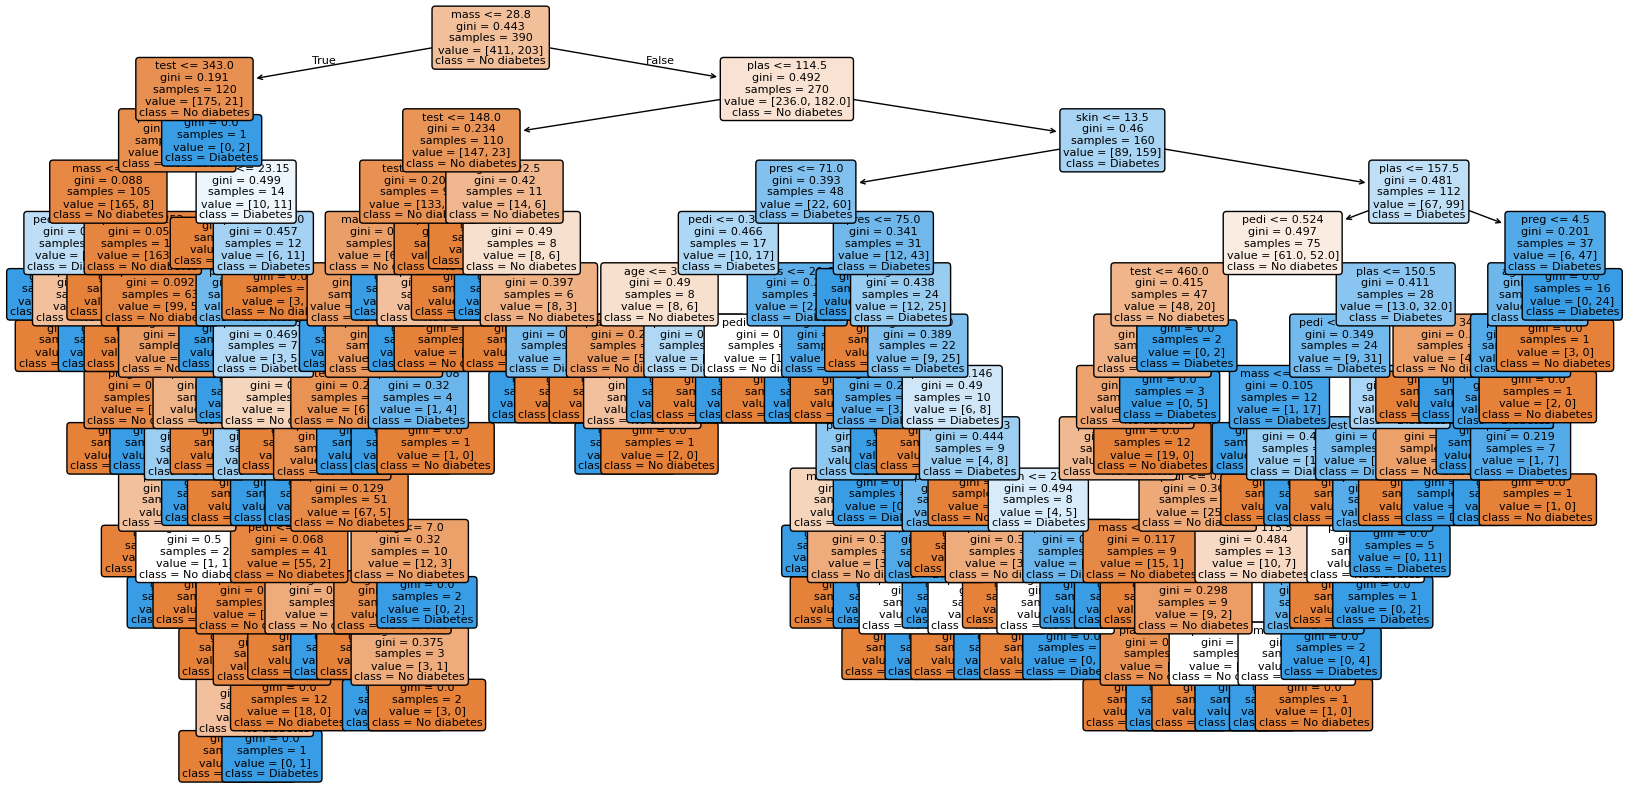

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Elegimos el árbol número 0 del Random Forest
estimator = mejor_modelo.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(estimator, 
          feature_names=X_train.columns, 
          class_names=["No diabetes", "Diabetes"],
          filled=True, 
          rounded=True,
          fontsize=8)
plt.show()

In [24]:
import pandas as pd

importances = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': mejor_modelo.feature_importances_
}).sort_values('importancia', ascending=False)

importances

,variable,importancia
1,plas,0.266073
5,mass,0.161420
7,age,0.130861
6,pedi,0.127089
2,pres,0.086335
0,preg,0.084277
4,test,0.073752
3,skin,0.070194


In [25]:
from sklearn.tree import export_text

tree_text = export_text(estimator, feature_names=list(X_train.columns))
print(tree_text)

|--- mass <= 28.80
|   |--- test <= 343.00
|   |   |--- plas <= 145.50
|   |   |   |--- mass <= 9.10
|   |   |   |   |--- pedi <= 0.24
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- pedi >  0.24
|   |   |   |   |   |--- preg <= 7.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- preg >  7.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- mass >  9.10
|   |   |   |   |--- pedi <= 0.25
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- pedi >  0.25
|   |   |   |   |   |--- plas <= 118.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- plas >  118.50
|   |   |   |   |   |   |--- age <= 33.50
|   |   |   |   |   |   |   |--- preg <= 6.00
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- preg >  6.00
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- age >  33.50
|   |   |   |   |   |   |   |--- pedi <= 0.57
|   |   |   |   |   |   |   |   |--- mass <= 26.20
|   |   |   |   